In [144]:
import scipy.stats as ss
import matplotlib.pyplot as plt
import numpy as np 
from scipy.special import rel_entr
import scipy.stats as stats

Declaremos una distribución y verifiquemos que la distribución es lo que esperamos 

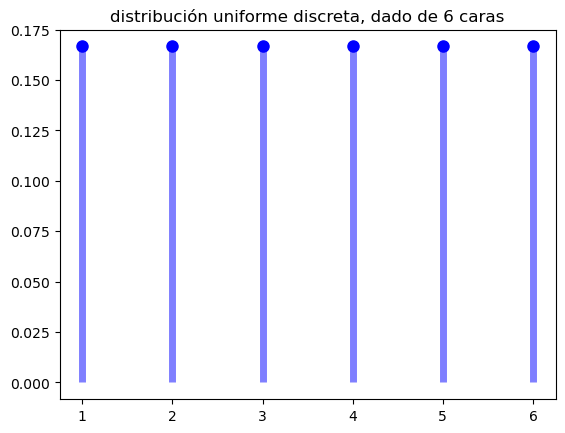

In [120]:
low, high = 1, 7

fig, ax = plt.subplots(1, 1)
x = np.arange(ss.randint.ppf(0.01, low, high+1),
              ss.randint.ppf(0.99, low, high+1))

ax.plot(x, ss.randint.pmf(x, low, high), 'bo', ms=8, label='randint pmf')
ax.vlines(x, 0, ss.randint.pmf(x, low, high), colors='b', lw=5, alpha=0.5)
plt.title("distribución uniforme discreta, dado de %d caras"%(high-low))
plt.show()

A continuación declaramos 3 funciones:
 - rel_freq: calcula la frecuencia relativa de una muestra, el vector devuelto tiene tantos o menos elementos como caras el dado, no hay frecuencas nulas 
 - experimento_muestral: la versión original, calcula el promedio de las frecuencias en un size-nuestreo 
 - every_freq: Similar a rel_freq, entregas las frecuencias relativas, pero en el orden, si una frecuancia es 0, es porque no se visitó ese estado/cara del dado

In [48]:
randomState= ss.randint.rvs(0, 1000, size=10, random_state=42)

def rel_freq(sample, values=False):
    '''Funcion que devuelve la frecuancia relativa de los elementos de x '''
       
    freqs = [(value, np.count_nonzero(sample==value) / len(sample)) for value in set(sample)] 
    
    if values: 
        return freqs
    else: 
        return np.array(freqs)[:,1]
    

def experimento_muestras(low, high, size=15, random_state=42):
    '''
    Función aleatoria que devuelve el resultado de simular el  experimento *una vez*.
    El resultado es distinto cada vez que llamamos a la función.
    El resultado es un promedio a partir de una muestra de tamaño _size_
    '''
    sample = ss.randint.rvs(low, high, size=size, random_state=random_state)
    freqs = [ np.count_nonzero(sample==value) / len(sample) for value in set(sample)] 
    
    return np.mean(freqs) #ignore

def every_freq(low, high, size=15, random_state=42):
    '''La función toma un vector que podría, potencialmente ser más corto y lo inserta en una más largo
    (de largo el numero de enteros en al distro uniforme), de tal manera de que los elementos faltantes tengan frecuancia 0'''
    
    sample = ss.randint.rvs(low, high, size=size, random_state=random_state)
    freqs = [(value, np.count_nonzero(sample==value) / len(sample)) for value in set(sample)] 
    
    l = sorted((freqs, np.zeros(high-low)), key=len)
    
    c = l[1].copy()
    
    for i in freqs:
        c[i[0]-1] += i[1]
    
    
    return np.array(c)   


Ahora usemos  un array (randomState) con semillas aleatorias para asegurarnos que no estamos repitiendo el ejercicios futilmente

- La función _stat.entropy(*a*,*b*)_ al igual que _rel_entr(*a*,*b*)_, entregan la entropía relativa entre distribuciones *a* y *b*, en ambos casos es necesario que *a* y *b* tengan elmismo largo
- n_sims= convierte las iteraciones(iter) en una matris de *iter x (high-low)* con las frecuencias relativas de vada una de las iteraciones de tirar el dado _sample_size_ veces

In [138]:
unif= ss.randint.pmf(x, low, high)
iter, sample_size =1000, 50

randomState= ss.randint.rvs(0, 1000, size=iter, random_state=42)
# [sum(stat.entropy(every_freq(low, high, size=25, random_state=i), unif)) for i in randomState]
n_sims=np.stack([every_freq(low, high, size=sample_size, random_state=i) for i in randomState])

print("(%d iteraciones, lanzar el dado %d veces, %d estados/caras)="%(iter, sample_size ,(high-low)), n_sims.shape)

(1000 iteraciones, lanzar el dado 50 veces, 6 estados/caras)= (1000, 6)


Vale la pena preguntarnos, en las columna ¿ como distribuyen los datos? Beta cada columna, Dirichlet entre todas ellas. ¿Cómo distribuyen las filas? las filas deberían tender a ser uniformes en la medida que aumentamos *sample_size*. 

Para pocas caras, hagamos la gráfica

Promedio de cada estado=  [0.1625  0.16382 0.16894 0.17264 0.16726 0.16484]


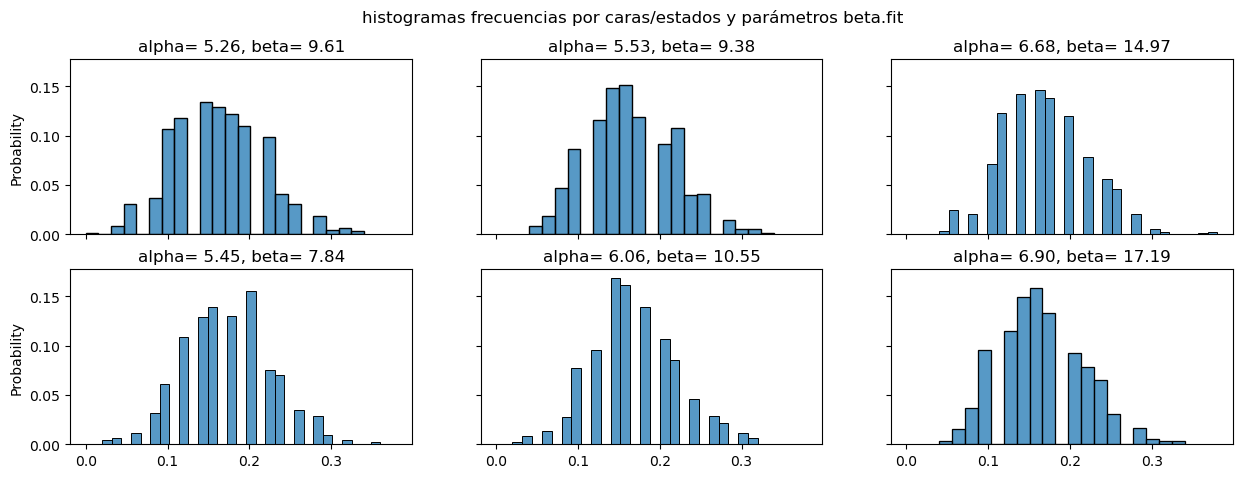

In [200]:
fig, axes = plt.subplots(2, (high-low)//2, sharex=True, sharey=True, figsize=(15,5))
fig.suptitle('histogramas frecuencias por caras/estados y parámetros beta.fit')

for i in range((high-low)):
    [alpha, beta, _, _ ] = stats.beta.fit(n_sims[:,i], floc=0)
    if i<(high-low)//2:
        hist=sns.histplot(data=n_sims[:,i], ax=axes[0,i], stat= "probability")
    else:
        hist=sns.histplot(data=n_sims[:,i], ax=axes[1,(i-(high-low)//2)], stat= "probability")
    hist.set(title="alpha= %.2f, beta= %.2f"% (alpha, beta))    

print("Promedio de cada estado= ", np.mean(n_sims, axis =0)) 

Podríamos contar los estados no visitados por cada iteración (¿$\sim Geo$, $\sim Bin$, $\sim neg\_Bin$?) y preguntarnos para qué *sample_size* tenemos un 95% de las simulaciones con 0 frecencias nulas 

Si quisieramos usar la maquinaria para distribuciones normales, necesitamos promedios $\bar{X}$, ya que sabemos que $\bar{X}\sim N(\mu,\sigma^2)$.
*Idea: sacar los promedios para cada columna de n_sims y trabajar ahí*

[Text(0.5, 0, 'estados sin vistar'),
 Text(0.5, 1.0, 'histogrma estados sin visitar 6D, 1000 sims, n=50/sim')]

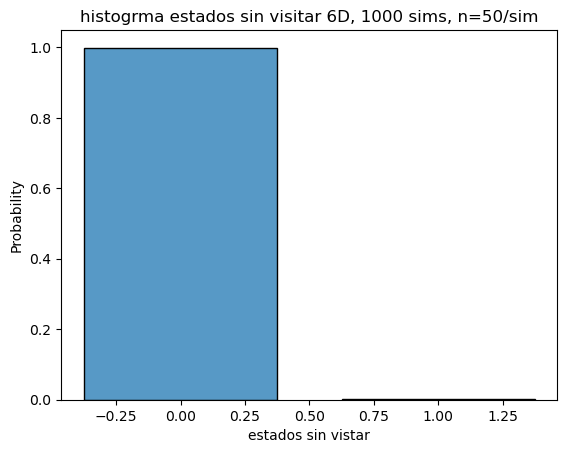

In [143]:
conteo= np.count_nonzero(n_sims==0., axis=1)
hist=sns.histplot(conteo, bins= [1,2,3,4], stat= "probability", discrete=True, shrink=0.75)
hist.set(xlabel="estados sin vistar", title="histogrma estados sin visitar %dD, %d sims, n=%d/sim"%((high-low),iter, sample_size) )